In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.integrate import trapezoid

In [2]:
a = np.arange(9).reshape(3,3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [3]:
kernel = np.ones((3,3)) / 9
kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [4]:
convolve(a, kernel, mode="same")

array([[0.88888889, 1.66666667, 1.33333333],
       [2.33333333, 4.        , 3.        ],
       [2.22222222, 3.66666667, 2.66666667]])

# PSF definition and normalization

In [5]:
from functools import partial


params_psfx = {
    "center": 0,
    "alpha": 0.0016,
    "beta": 0.6938,
}

params_psfy = {
    "center": 0,
    "alpha": 0.3214,
    "beta": 0.6246,
}


def modsech(x, norm, center, alpha, beta):
    return norm / np.cosh(np.abs((x - center) / alpha) * beta) 

psfx = partial(modsech, norm=1., **params_psfx)
psfy = partial(modsech, norm=1., **params_psfy)

def norm_constant(center, alpha, beta):
    xs = np.linspace(-50*alpha, +50*alpha, 10000)
    return 1 / trapezoid(
        y = modsech(xs, norm=1, center=center, alpha=alpha, beta=beta),
        x = xs,
    )

def norm_modsech(center, alpha, beta):
    norm = norm_constant(center, alpha, beta)
    return partial(modsech, norm=norm, center=center, alpha=alpha, beta=beta)

norm_psfx = norm_modsech(**params_psfx)
norm_psfy = norm_modsech(**params_psfy)

In [6]:
print(f"the x normalization constant is: {norm_constant(center=0, alpha=0.0016, beta=0.6938)}")
print(f"the y normalization constant is : {norm_constant(center=0, alpha=0.3214, beta=0.6246)}")

the x normalization constant is: 138.02712439644637
the y normalization constant is : 0.6185947570329887


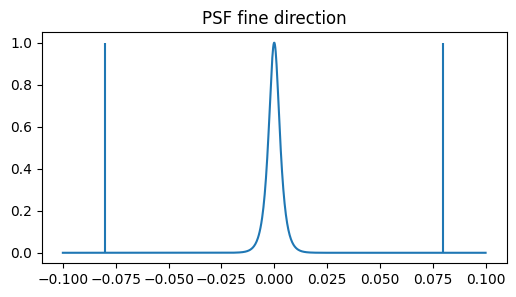

In [7]:
alpha_x = 0.0016
xs = np.linspace(-0.1, + 0.1, 1000)
ys = psfx(xs)

plt.figure(figsize=(6, 3))
plt.plot(xs, ys)
plt.vlines([-alpha_x * 50, alpha_x * 50], ymin =0, ymax=ys.max())
plt.title("PSF fine direction")
plt.semilogy
plt.show()

In [8]:
ys_ = norm_psfx(xs)
print(trapezoid(ys_, xs))

1.0000000000000013


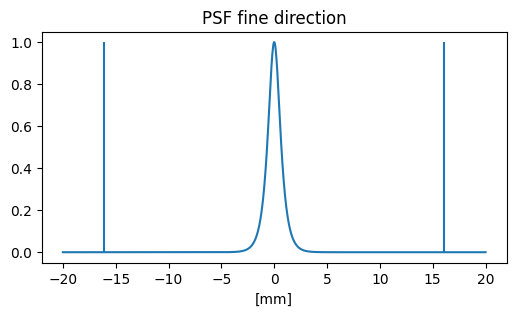

In [9]:
alpha_y = 0.3214
xs = np.linspace(-20, +20, 1000)
ys = psfy(xs)

plt.figure(figsize=(6, 3))
plt.plot(xs, ys)
plt.title("PSF fine direction")
plt.vlines([-alpha_y * 50, alpha_y * 50], ymin =0, ymax=ys.max())
plt.xlabel("[mm]")
plt.show()

In [10]:
ys_ = norm_psfy(xs)
print(trapezoid(ys_, xs))

1.0000000000000349


# Kernel definition

In [11]:
from iros.mask import fetch_camera, _bisect_interval
from iros.assets import path_wfm_mask

wfm = fetch_camera(path_wfm_mask, (1, 1))
bins = wfm.bins_detector

In [12]:
min_bin, max_bin = _bisect_interval(np.round(bins.x, 2), -0.5, +0.5)
bin_edges = bins.x[min_bin: max_bin + 1]
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2

In [13]:
midpoints, norm_psfx(midpoints)

(array([-0.375, -0.125,  0.125,  0.375]),
 array([6.61668055e-69, 7.95932698e-22, 7.95932698e-22, 6.61668055e-69]))

In [14]:
bin_edges

array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ])

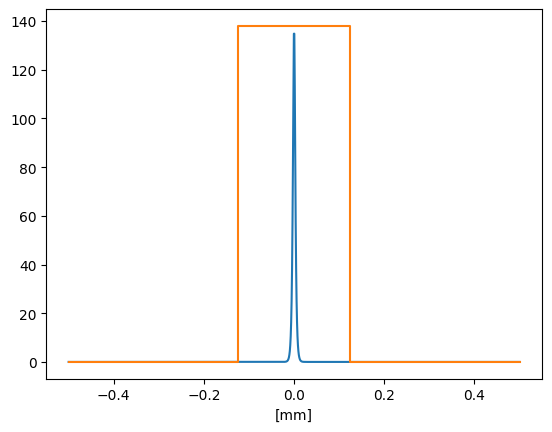

In [15]:
xs = np.linspace(bin_edges[0], bin_edges[-1], 1000)
ys = norm_psfx(xs)

plt.plot(xs, ys)
plt.step(bin_edges, norm_psfx(bin_edges), where="mid")
plt.xlabel("[mm]")
plt.show()

We see that at tipical upscaling, the psf in the fine direction falls comfortably inside a bin.

In [16]:
min_bin, max_bin = _bisect_interval(np.round(bins.y, 2), -5, +5)
bin_edges = bins.y[min_bin: max_bin + 1]
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2

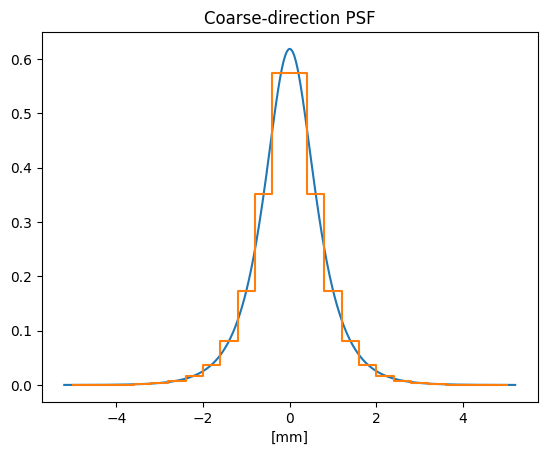

In [17]:
xs = np.linspace(bin_edges[0], bin_edges[-1], 1000)
ys = norm_psfy(xs)

plt.plot(xs, ys)
plt.step(midpoints, norm_psfy(midpoints), where="mid")
plt.xlabel("[mm]")
plt.title("Coarse-direction PSF")
plt.show()

# Image convolution

convolve image with kernel

In [19]:
from iros.io import fetch_simulation
from iros.mask import fetch_camera, encode, decode, count, _bisect_interval
from iros.images import compose, argmax
from iros.assets import path_wfm_mask

sdl = fetch_simulation("/home/deppep/Dropbox/Progetti/masks/simulations/id00/")
wfm = fetch_camera(path_wfm_mask, (5, 8))

detector_detected_1a = count(wfm, sdl.detected["cam1a"])
detector_reconstructed_1a = count(wfm, sdl.reconstructed["cam1a"])

In [20]:
bins = wfm.bins_detector
min_bin, max_bin = _bisect_interval(np.round(bins.y, 2), -5, +5)
bin_edges = bins.y[min_bin: max_bin + 1]
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
kernel = norm_psfy(midpoints).reshape(len(midpoints), -1)
kernel = kernel / np. sum(kernel)

In [21]:
convolved = convolve(detector_detected_1a, kernel, mode="same")

In [22]:
np.sum(detector_reconstructed_1a), np.sum(detector_detected_1a), np.sum(convolved)

(np.float64(426027.0), np.float64(426241.0), np.float64(424540.77808965975))

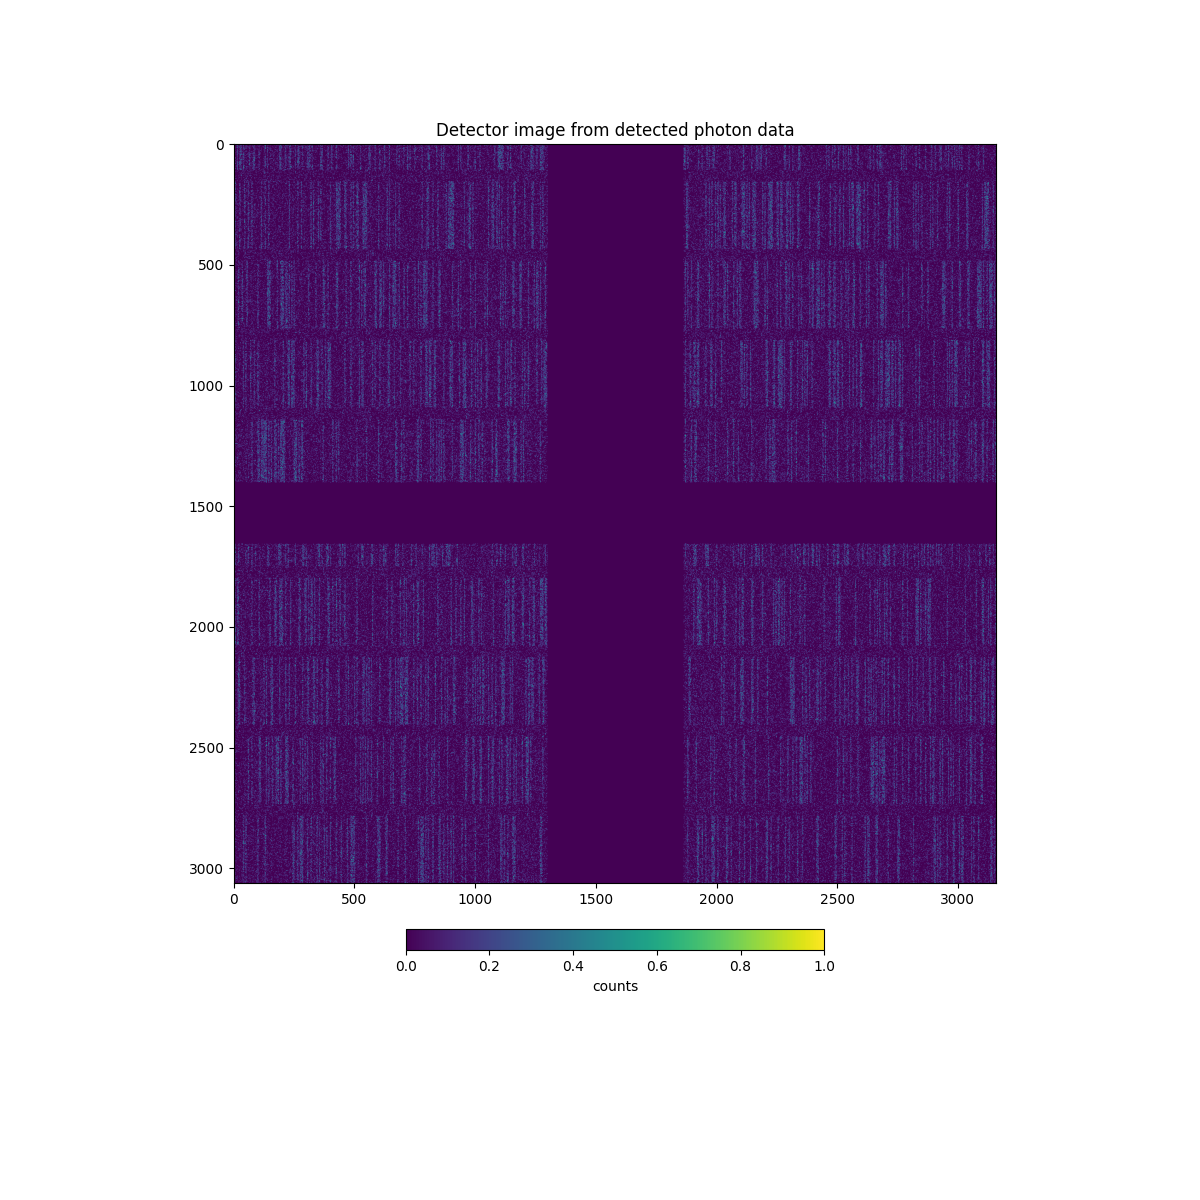

In [26]:
%matplotlib ipympl

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(detector_detected_1a, vmax=1)
fig.colorbar(c0, ax=ax, label="counts", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Detector image from detected photon data")
plt.show()

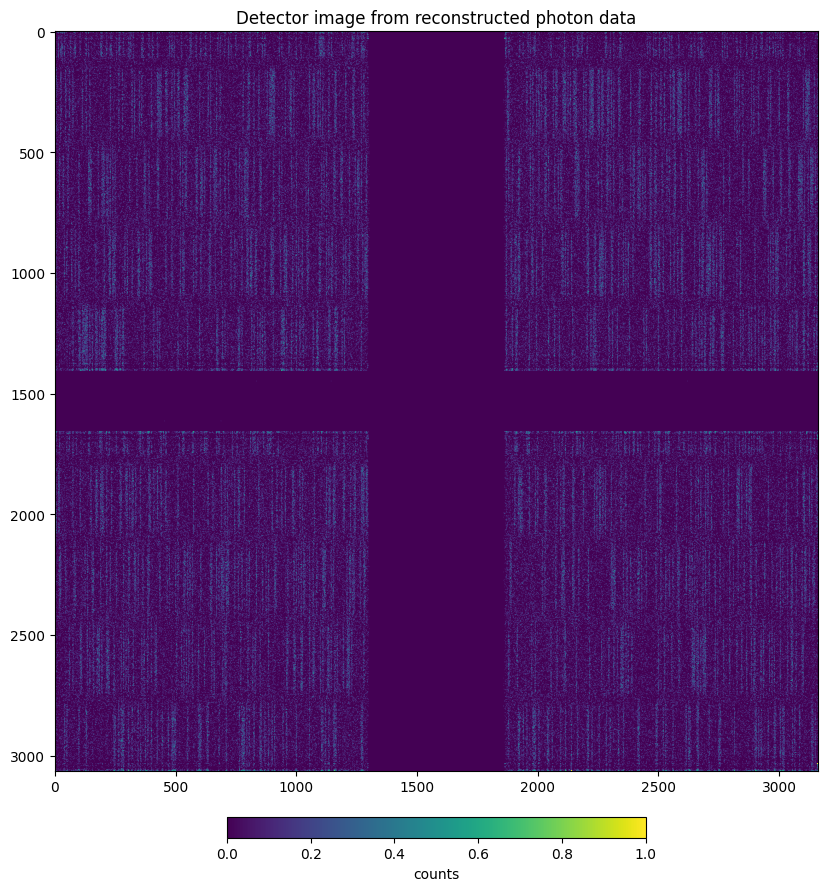

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(detector_reconstructed_1a, vmax=1)
fig.colorbar(c0, ax=ax, label="counts", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Detector image from reconstructed photon data")
plt.show()

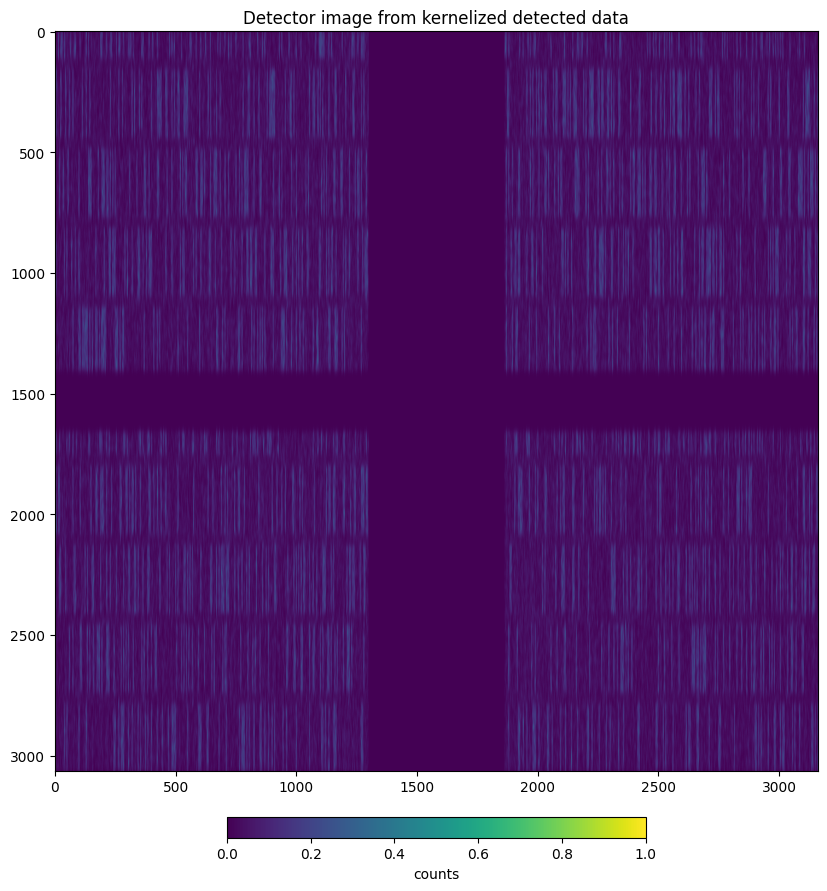

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(convolved, vmax=1)
fig.colorbar(c0, ax=ax, label="counts", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Detector image from kernelized detected data")
plt.show()